## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Upload all dataset files into colab/Files/sample_data

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [13]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00


In [14]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [1]:
#dataset = nlp.load_dataset('emotion')

import pandas as pd

In [3]:
#train = dataset['train']
#val = dataset['validation']
#test = dataset['test']

train = pd.read_csv('/content/sample_data/training.csv')
val = pd.read_csv('/content/sample_data/validation.csv')
test = pd.read_csv('/content/sample_data/test.csv')

In [4]:
def get_tweets(data):
    #tweets = [x['text'] for x in data]
    #labels = [x['label'] for x in data]

    tweets = data['text'].tolist()
    labels = data['label'].tolist()

    return tweets, labels

In [5]:
tweets, labels = get_tweets(train)

In [6]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
# Anything that not present for 10000 word assignmend as <UNK>
tokenizer.fit_on_texts(tweets)

In [9]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 680]]

In [10]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

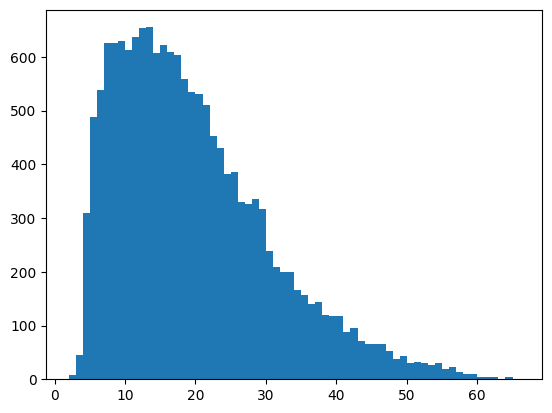

In [15]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths))) # histogram
plt.show()

In [16]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen)
  # if length is less than 50 then untill makes length 50 adding padding 'post
  # also if length is greater than 50 then truncate it to length 50
  return padded

In [18]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [19]:
padded_train_seq[0]

array([  2, 139,   3, 680,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [20]:
classes = set(labels)
print(classes)

{'joy', 'fear', 'surprise', 'sadness', 'love', 'anger'}


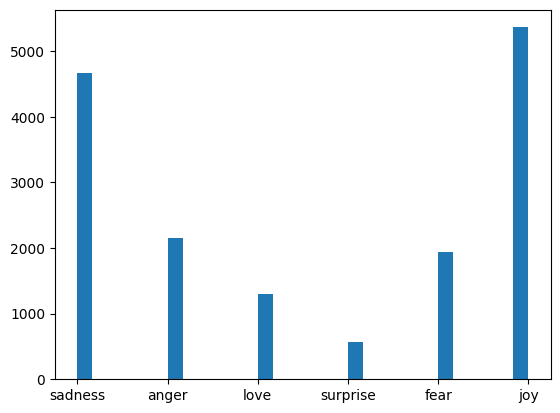

In [21]:
plt.hist(labels, bins=30)
plt.show()

In [22]:
#convert name of classes to corresponding numeric value

class_to_index = dict((c,i) for i,c in enumerate(classes)) # creating dictionary
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [23]:
class_to_index

{'joy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'love': 4, 'anger': 5}

In [24]:
index_to_class

{0: 'joy', 1: 'fear', 2: 'surprise', 3: 'sadness', 4: 'love', 5: 'anger'}

In [25]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [26]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    # 10000 is input dimension 16 is output dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # LSTM can go left to right and vice versa
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy', # for multiclass
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [29]:
val_tweets, val_labels = get_tweets(val)
padded_val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)


In [30]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [31]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(padded_val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
        #if the models does not see any impovement over 2 epoch the it will stop training
    ]
)

Epoch 1/20
500/500 [==============================] - 38s 63ms/step - loss: 1.3027 - accuracy: 0.4690 - val_loss: 0.7886 - val_accuracy: 0.7215
Epoch 2/20
500/500 [==============================] - 28s 55ms/step - loss: 0.5724 - accuracy: 0.7762 - val_loss: 0.5882 - val_accuracy: 0.7855
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3372 - accuracy: 0.8846 - val_loss: 0.4580 - val_accuracy: 0.8605
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1923 - accuracy: 0.9394 - val_loss: 0.4301 - val_accuracy: 0.8680
Epoch 5/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1333 - accuracy: 0.9577 - val_loss: 0.4153 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0958 - accuracy: 0.9712 - val_loss: 0.4123 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 31s 62ms/step - loss: 0.0910 - accuracy: 0.9717 - val_loss: 0.4204 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

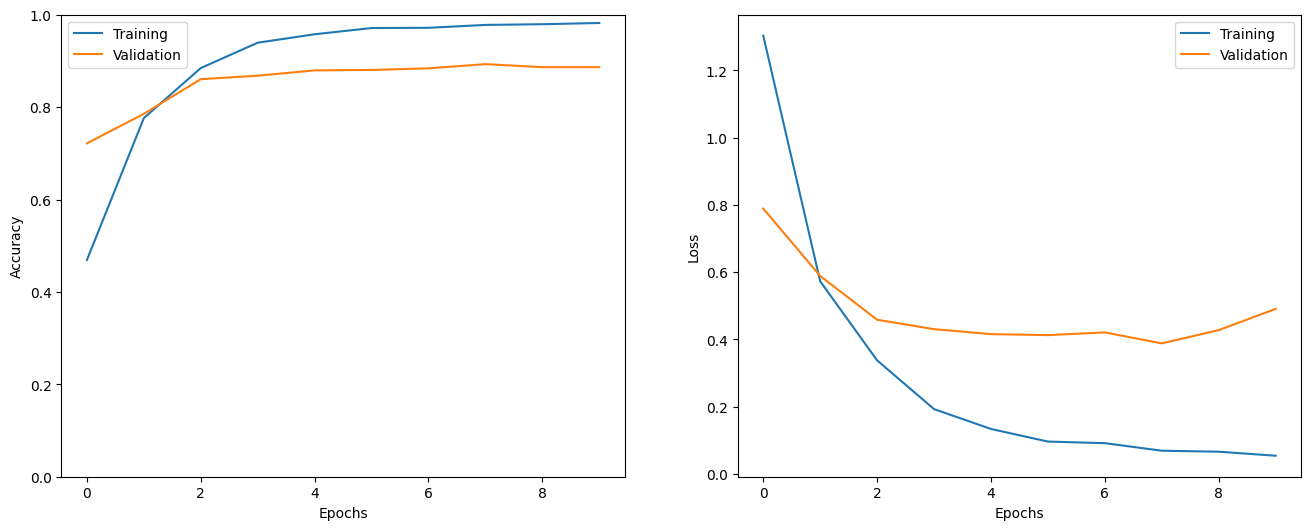

In [32]:
show_history(h)

In [33]:
test_tweets, test_labels = get_tweets(test)
padded_test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [34]:
h1 = model.evaluate(padded_test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4701 - accuracy: 0.8815


In [35]:
i = random.randint(0, len(test_labels)-1)

print('sentence: ',test_tweets[i])
print('Emotion: ',index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')] # convert it into int using unit8

print('predicted emotion: ',pred_class)

sentence:  i felt confused me sometimes that makes me feel useless
Emotion:  sadness
1/1 [==============================] - 2s 2s/step
predicted emotion:  sadness


In [36]:
#preds = model.predict_classes(padded_test_seq)
preds = model.predict(padded_test_seq)

63/63 [==============================] - 1s 15ms/step


In [50]:
#confusion_matrix(test_labels, preds.argmax(axis=1), list(classes))
